In [1]:
import copy
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import random
import sys
from importlib import reload
import scanpy as sc

In [2]:
import os
source_path = os.path.abspath("../utilities/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2
print(sys.path)

['/home/sgolts/.conda/envs/porky/lib/python310.zip', '/home/sgolts/.conda/envs/porky/lib/python3.10', '/home/sgolts/.conda/envs/porky/lib/python3.10/lib-dynload', '', '/home/sgolts/.conda/envs/porky/lib/python3.10/site-packages', '/home/sgolts/research/higher-order-single-cell/notebooks/utilities']


## Load Data

In [3]:
import glob
import time

In [4]:
resolution = 1000000
chrom = "chr7"

dpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/pipeline_outputs/higher_order/by_chromosome/"

file_list = sorted(glob.glob(f"{dpath}*_{resolution}_{chrom}*"))
print(file_list)

population_path = file_list[0]
singlecell_path = file_list[1]

print()

print(f"{population_path=}")
print(f"{singlecell_path=}")

['/nfs/turbo/umms-indikar/shared/projects/poreC/pipeline_outputs/higher_order/by_chromosome/population_mESC_1000000_chr7.h5ad', '/nfs/turbo/umms-indikar/shared/projects/poreC/pipeline_outputs/higher_order/by_chromosome/singlecell_mESC_1000000_chr7.h5ad']

population_path='/nfs/turbo/umms-indikar/shared/projects/poreC/pipeline_outputs/higher_order/by_chromosome/population_mESC_1000000_chr7.h5ad'
singlecell_path='/nfs/turbo/umms-indikar/shared/projects/poreC/pipeline_outputs/higher_order/by_chromosome/singlecell_mESC_1000000_chr7.h5ad'


In [5]:
start_time = time.time()  # Record the start time
adata = sc.read_h5ad(population_path)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
sc.logging.print_memory_usage()
adata

Time taken to read the file: 3.75 seconds
Memory usage: current 0.36 GB, difference +0.36 GB


AnnData object with n_obs × n_vars = 142 × 85534
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'PolII', 'chrom_degree'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'

In [6]:
start_time = time.time()  # Record the start time
bdata = sc.read_h5ad(singlecell_path)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
sc.logging.print_memory_usage()
bdata

Time taken to read the file: 20.36 seconds
Memory usage: current 1.45 GB, difference +1.09 GB


AnnData object with n_obs × n_vars = 142 × 851428
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'PolII', 'chrom_degree'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'

In [7]:
bdata.var['basename']

read_name
e6f2abec-2d2e-4fc1-ac1f-93b8d7278a0c    o3b43
30fe027b-54af-4b04-af64-26be53c9890b    o3b43
322a685f-b087-44d5-afd4-c12955917201    o3b43
75b6fff9-f7fc-41a0-9490-f7c2b7e8a8a0    o3b43
c9c006d9-353b-48fe-afd0-087266b992d8    o3b43
                                        ...  
26888535-a92e-575b-8f3b-298c3cfdabd8    o1b43
50adc41b-cabc-40db-9dec-d12ba1f6d44a    o1b56
32877f90-dbd0-487e-b20e-5a730078af64    o4b07
007ce5ba-72de-414d-ba82-9b1b6be206f3    o3b08
fb981ad1-baf9-4d95-86b5-3550da011b02    o1b56
Name: basename, Length: 851428, dtype: category
Categories (349, object): ['o1b01', 'o1b02', 'o1b03', 'o1b04', ..., 'o4b93', 'o4b94', 'o4b95', 'o4b96']

## QC

In [8]:
def find_outliers_iqr(df_column):
  """
  Identifies outliers in a pandas DataFrame column using the IQR method.

  Args:
    df_column: A pandas Series representing the column to analyze.

  Returns:
    A boolean mask with True for outliers and False otherwise.
  """
  Q1 = df_column.quantile(0.15)
  Q3 = df_column.quantile(0.85)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return (df_column < lower_bound) | (df_column > upper_bound)

adata.obs['degree_outlier'] = find_outliers_iqr(adata.obs['chrom_degree'])

adata.obs[adata.obs['degree_outlier']][['chrom_bin', 'chrom_degree', 'degree_outlier']].head()

,chrom_bin,chrom_degree,degree_outlier
bin_name,,,
chr7:7,7,2476,True
chr7:8,8,2416,True
chr7:20,20,797,True
chr7:21,21,726,True
chr7:22,22,740,True


In [9]:
# remove outliers
remove_bins = adata.obs[adata.obs['degree_outlier']].index.to_list()
print(f"Removing top {len(remove_bins)} outlier loci: ")
print(remove_bins)

adata = adata[~adata.obs_names.isin(remove_bins), :].copy()
bdata = bdata[~bdata.obs_names.isin(remove_bins), :].copy()

print('done!')

Removing top 5 outlier loci: 
['chr7:7', 'chr7:8', 'chr7:20', 'chr7:21', 'chr7:22']
done!


# Clique Expand

In [10]:
matrix.expand_and_normalize_anndata(adata, oe_kr=True)
matrix.expand_and_normalize_anndata(bdata, oe_kr=True)

adata

Expanding input matrix...
Applying KR normalization...
Applying OE normalization...
Normalization complete.
Expanding input matrix...
Applying KR normalization...
Applying OE normalization...
Normalization complete.


AnnData object with n_obs × n_vars = 137 × 85534
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'PolII', 'chrom_degree', 'degree_outlier'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'
    obsm: 'A', 'A_kr', 'A_oe', 'A_oe_kr'

In [11]:
import time

incidence_matrices = {}
cell_ids = bdata.var['basename'].unique()

# Only take the first 5 cells
cell_ids_subset = cell_ids[:5]
num_cells = len(cell_ids_subset)
total_time = 0.0

for i, cell_id in enumerate(cell_ids_subset):
    start_time = time.time()

    # extract the single-cell
    sc_data = bdata[:, bdata.var['basename'] == cell_id].copy()
    H_o = sc_data.to_df()
    H_o = H_o.T.drop_duplicates().T  # Transpose, drop duplicates, transpose back
    H_o.columns = [f"{cell_id}_{x}" for x in H_o.columns]

    incidence_matrices[cell_id] = H_o

    # Timing info
    elapsed_time = time.time() - start_time
    total_time += elapsed_time

    print(f"Processed {i+1}/{num_cells} cells. "
          f"Time for this cell: {elapsed_time:.2f} seconds, "
          f"Cumulative time: {total_time:.2f} seconds")

print("Finished processing 5 cells.")

Processed 1/5 cells. Time for this cell: 1.04 seconds, Cumulative time: 1.04 seconds
Processed 2/5 cells. Time for this cell: 0.33 seconds, Cumulative time: 1.37 seconds
Processed 3/5 cells. Time for this cell: 0.20 seconds, Cumulative time: 1.57 seconds
Processed 4/5 cells. Time for this cell: 0.20 seconds, Cumulative time: 1.77 seconds
Processed 5/5 cells. Time for this cell: 0.24 seconds, Cumulative time: 2.01 seconds
Finished processing 5 cells.


In [12]:
# print(incidence_matrices.keys())
# for cell_id, H in incidence_matrices:
#     print(H.rows[:5])

In [13]:
start_time = time.time()

# Directly extract the whole population matrix
pop_matrix = adata.to_df()
pop_matrix = pop_matrix.T.drop_duplicates().T  # clean duplicates
pop_matrix.columns = [f"pop_{x}" for x in pop_matrix.columns]

elapsed_time = time.time() - start_time
print(f"Population incidence matrix built in {elapsed_time:.2f} seconds.")

# Save separately
population_incidence_matrix = pop_matrix

Population incidence matrix built in 0.43 seconds.


In [14]:
print(population_incidence_matrix.columns)

Index(['pop_9052b9ea-478f-4351-bc31-6a0a3f9becb5',
       'pop_a7d58484-4b6f-4498-960b-71d8229b3d94',
       'pop_d069851e-2ad6-4ac4-9df1-6a09921b3b7e',
       'pop_ca19a9ca-93bd-4c37-863e-7ec6768a12aa',
       'pop_7bd11f1d-e455-43ff-8f2a-885d6caa5783',
       'pop_fc1788be-74e9-4875-9564-dc0d34afffec',
       'pop_a41bcd05-ced9-4c1a-80a7-6d9097ae23c9',
       'pop_9d92ade2-0ef0-419e-9d38-9d2e46340516',
       'pop_692d1dd5-faf7-43b1-b9d5-ce67cbf0d583',
       'pop_1f123743-8068-44df-bf10-525be3dc67c7',
       ...
       'pop_c5b1431c-b3f8-4ee8-886b-0a3688e3de11',
       'pop_656f5de4-87d5-4bd7-8757-8ec432858f45',
       'pop_3b429166-8d76-4026-a20a-368bda22d33e',
       'pop_a6f6a2bd-1bd5-44e2-be36-69efc151a158',
       'pop_cf5509cc-3dba-40c7-94ea-78956974f41d',
       'pop_8a4fb348-13be-480d-a13d-08c20d88668b',
       'pop_759f935e-d8e3-4150-bc72-d5966dc751f7',
       'pop_08a5edda-3dd9-4094-b9d5-9dcc2baaea67',
       'pop_4cf9fd8c-44ad-4dcb-a0c0-a856cf66faf7',
       'pop_43f154f8

In [15]:
# # Plot each incidence matrix directly, no saving
# for cell_id, H in incidence_matrices.items():
#     if H is None or H.shape[0] == 0 or H.shape[1] == 0 or np.all(H.values == 0):
#         continue  # skip empty ones

#     rows, cols = np.nonzero(H.to_numpy())
#     if len(rows) == 0:
#         continue

#     plt.figure(figsize=(8, 3.0), dpi=150)
#     plt.scatter(cols, rows, s=2, marker='s', alpha=0.8, linewidths=0)

#     plt.gca().invert_yaxis()
#     plt.xlabel("read index")
#     plt.ylabel("bin index (chr7)")
#     plt.title(f"Incidence (chr7): {cell_id}\n(rows={H.shape[0]}, cols={H.shape[1]})")
#     plt.xticks([])
#     plt.show()

In [16]:
# H_pop = population_incidence_matrix

# if H_pop.shape[1] == 0 or np.all(H_pop.values == 0):
#     print("Population incidence matrix is empty.")
# else:
#     rows, cols = np.nonzero(H_pop.to_numpy())

#     plt.figure(figsize=(10, 3.5), dpi=150)
#     plt.scatter(cols, rows, s=1, marker='.', alpha=0.8, linewidths=0)

#     plt.gca().invert_yaxis()
#     plt.xlabel("read index (population)")
#     plt.ylabel("bin index (chr7)")
#     plt.title(f"Population incidence (chr7)  [rows={H_pop.shape[0]}, cols={H_pop.shape[1]}]")
#     plt.xticks([])
#     plt.show()

In [17]:
def kway_counts_from_incidence(H: pd.DataFrame, unique_only: bool = False) -> pd.DataFrame:
    """
    Count k-way interactions for one incidence matrix H (rows=bins, cols=reads).
    """
    if unique_only:
        H = H.T.drop_duplicates().T  # remove duplicate reads

    # binarize to 0/1
    Hb = (H.to_numpy() > 0).astype(np.int32)

    # order of each hyperedge = column sum
    orders = Hb.sum(axis=0)

    vc = pd.value_counts(orders).sort_index()
    out = pd.DataFrame({"k": vc.index.astype(int),
                        "n_edges": vc.values}).reset_index(drop=True)
    out["fraction"] = out["n_edges"] / out["n_edges"].sum()

    # cumulative counts (≥k)
    out["n_edges_ge_k"] = out["n_edges"][::-1].cumsum()[::-1]
    out["fraction_ge_k"] = out["n_edges_ge_k"] / out["n_edges"].sum()
    return out

def kway_counts_per_cell(incidence_matrices: dict, unique_only: bool = False) -> pd.DataFrame:
    """
    Compute k-way counts for each cell in a dict of incidence matrices,
    plus an aggregate across all cells.
    """
    records, all_ks = [], set()
    for cell_id, H in incidence_matrices.items():
        if H is None or H.shape[1] == 0:
            continue
        df_counts = kway_counts_from_incidence(H, unique_only=unique_only)
        df_counts["cell"] = cell_id
        records.append(df_counts)
        all_ks.update(df_counts["k"].tolist())

    if not records:
        return pd.DataFrame(columns=["cell", "k", "n_edges", "fraction"])

    per_cell = pd.concat(records, ignore_index=True)

    # aggregate across all cells
    agg = (per_cell.groupby("k", as_index=False)["n_edges"].sum()
                     .sort_values("k").reset_index(drop=True))
    agg["fraction"] = agg["n_edges"] / agg["n_edges"].sum()
    agg["n_edges_ge_k"] = agg["n_edges"][::-1].cumsum()[::-1]
    agg["fraction_ge_k"] = agg["n_edges_ge_k"] / agg["n_edges"].sum()
    agg["cell"] = "ALL"

    return pd.concat([per_cell, agg], ignore_index=True)


In [18]:
counts_pop = kway_counts_from_incidence(population_incidence_matrix, unique_only=True)
print(counts_pop)

     k  n_edges  fraction  n_edges_ge_k  fraction_ge_k
0    0        1  0.000032         31645       1.000000
1    1      136  0.004298         31644       0.999968
2    2     8994  0.284216         31508       0.995671
3    3    13394  0.423258         22514       0.711455
4    4     5603  0.177058          9120       0.288197
5    5     2189  0.069174          3517       0.111139
6    6      826  0.026102          1328       0.041966
7    7      304  0.009607           502       0.015863
8    8      114  0.003602           198       0.006257
9    9       43  0.001359            84       0.002654
10  10       23  0.000727            41       0.001296
11  11       11  0.000348            18       0.000569
12  12        4  0.000126             7       0.000221
13  13        2  0.000063             3       0.000095
14  20        1  0.000032             1       0.000032


/tmp/ipykernel_2521920/675253657.py:14: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  vc = pd.value_counts(orders).sort_index()


## Better Plots

In [19]:
H = adata.to_df()
H.index = adata.obs['chrom_bin'].values
H = H.sort_index()
print(f"{H.shape=}")
H.head()

H.shape=(137, 85534)


read_name,9052b9ea-478f-4351-bc31-6a0a3f9becb5,a7d58484-4b6f-4498-960b-71d8229b3d94,d069851e-2ad6-4ac4-9df1-6a09921b3b7e,ca19a9ca-93bd-4c37-863e-7ec6768a12aa,7bd11f1d-e455-43ff-8f2a-885d6caa5783,fc1788be-74e9-4875-9564-dc0d34afffec,a41bcd05-ced9-4c1a-80a7-6d9097ae23c9,9d92ade2-0ef0-419e-9d38-9d2e46340516,692d1dd5-faf7-43b1-b9d5-ce67cbf0d583,1f123743-8068-44df-bf10-525be3dc67c7,...,fc57485f-6b04-43ab-a2a1-cae737949941,a00a81c7-303c-49fc-9d21-f79fa729868a,43f154f8-466f-4670-9af7-d4acd3c522e8,7ece5ca8-ae14-49c8-96dd-ae295f185698,bc5b4b57-58f7-426d-9902-94e2b46735bd,33ff3077-a88a-4202-ae37-405881fc74e6,86404c84-f39d-421a-a38f-941375f49c73,b4ec0bbf-b10d-4b8c-9fe3-9a480d14d006,999ffa42-a4e8-495c-87e1-91a22551e726,ead1e6f3-4342-45dd-9af6-6206887052e1
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# sample_size = 85534
# pdf = ut.sort_by_lowest_index(H.T.sample(sample_size).T) # sample and sort

# # Calculate row and column sums
# row_sums = pdf.sum(axis=1)
# col_sums = pdf.sum(axis=0)

# # Create the heatmap
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 5, 3

# sns.heatmap(
#     data=pdf,
#     cmap='gnuplot',
#     cbar=False,
# )
# chromosome = 7
# plt.ylabel(f"Chromosome {chromosome} Loci")
# plt.xlabel(f"Pore-C Read")
# plt.xticks([])
# plt.yticks([])

In [21]:
# node_params = {
#     's' : 1,
#     'ec' : 'k',
#     'lw' : 1,
#     'marker' : ".",
#     'zorder' : 2,
# }

# line_params = {
#     'lw' : 0.1,
#     'alpha' : 0.5,
#     'zorder' : 1,
# }

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 8, 5

# sample_size = 500
# pdf = ut.sort_by_lowest_index(H.T.sample(sample_size).T)

# plt2.plot_incidence(
#     pdf, 
#     node_color='k',
#     node_params=node_params,
#     line_params=line_params,
# )

# plt.title(f"Chromosome {chromosome}")

In [22]:
from matplotlib.collections import LineCollection

def plot_incidence_fast(df, ax=None, node_color='k', line_color='k',
                        node_params=None, line_params=None,
                        draw_lines=False):
    """
    Vectorized incidence plot:
    - One scatter for all nonzeros (fast).
    - Optional LineCollection for vertical spans (fast-ish).
    """
    if ax is None:
        fig, ax = plt.subplots()

    node_params = dict(node_params or {})
    line_params = dict(line_params or {})

    # Avoid slow edge drawing on tiny markers
    node_params.setdefault('s', 1)
    node_params.setdefault('marker', '.')
    node_params.setdefault('linewidths', 0)
    node_params.pop('ec', None)    # was slowing things down
    node_params.pop('lw', None)

    # Convert to a boolean mask of nonzeros
    M = (df.values > 0)
    # Coordinates of nonzero entries
    rows, cols = np.where(M)

    # Map row indices to axis coords once
    yvals = df.index.to_numpy()
    x = cols
    y = yvals[rows]

    # One scatter for all points (rasterize helps PDF/large figs)
    ax.scatter(x, y, c=node_color, rasterized=True, **node_params)

    if draw_lines:
        # For each column, draw a vertical segment from min->max row that has a hit
        # Compute min and max row per column using vectorized ops
        # Set columns with no hits to NaN to skip them
        with np.errstate(invalid='ignore'):
            # Use argmin/argmax on masked arrays
            hits_per_col = M.any(axis=0)
            # Initialize mins/maxs
            min_row_idx = np.full(M.shape[1], np.nan, dtype=float)
            max_row_idx = np.full(M.shape[1], np.nan, dtype=float)
            # Only compute where there are hits
            if hits_per_col.any():
                # Positions of first/last True per column
                first = M.argmax(axis=0)
                # To get last True: flip and transform
                last = M.shape[0] - 1 - np.flip(M, axis=0).argmax(axis=0)

                # Map to y coordinates
                min_row_idx[hits_per_col] = yvals[first[hits_per_col]]
                max_row_idx[hits_per_col] = yvals[last[hits_per_col]]

            # Build segments for LineCollection (skip NaNs)
            valid = ~np.isnan(min_row_idx)
            seg_x = np.stack([np.where(valid)[0], np.where(valid)[0]], axis=1)
            seg_y = np.stack([min_row_idx[valid], max_row_idx[valid]], axis=1)

            # Assemble segments as ((x0,y0),(x1,y1)) for each column
            segments = np.stack([seg_x[:,0], seg_y[:,0], seg_x[:,1], seg_y[:,1]], axis=1)
            segments = segments.reshape(-1, 2, 2).astype(float)

            lc = LineCollection(segments, colors=line_color, rasterized=True, **line_params)
            ax.add_collection(lc)

    ax.invert_yaxis()
    ax.set_xlim(-0.5, df.shape[1] - 0.5)
    return ax

In [23]:
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = (8, 5)

# # You’re sampling all columns anyway; either lower it or keep as-is:
# # sample_size = min(5000, H.shape[1])  # MUCH faster to visualize
# # pdf = ut.sort_by_lowest_index(H.T.sample(sample_size, axis=0).T)

# # If you truly need all columns:
# #sample_size=200
# pdf = ut.sort_by_lowest_index(H)

# node_params = {'s': 1, 'marker': '.', 'linewidths': 0, 'zorder': 2}
# line_params = {'lw': 0.1, 'alpha': 0.3, 'zorder': 1}

# ax = plot_incidence_fast(
#     pdf,
#     node_color='k',
#     node_params=node_params,
#     line_params=line_params,
#     draw_lines=False,          # turn on only if needed
# )
# plt.title(f"Chromosome {chromosome}")
# plt.show()

In [24]:
# for cell_id, H in incidence_matrices.items():
#     if H is None or H.shape[0] == 0 or H.shape[1] == 0 or np.all(H.values == 0):
#         continue  # skip empty ones
#     H.index = H.index.str.split(":").str[1].astype(int)
    
#     node_params = {
#         's' : 1,
#         'ec' : 'k',
#         'lw' : 1,
#         'marker' : ".",
#         'zorder' : 2,
#     }

#     line_params = {
#         'lw' : 0.1,
#         'alpha' : 0.5,
#         'zorder' : 1,
#     }

#     plt.rcParams['figure.dpi'] = 200
#     plt.rcParams['figure.figsize'] = 8, 5

#     #sample_size = 100
#     #sample_size = min(H.shape[0], 1000)
#     pdf = ut.sort_by_lowest_index(H)

#     plt2.plot_incidence(
#         pdf, 
#         node_color='k',
#         node_params=node_params,
#         line_params=line_params,
#     )

#     plt.title(f"Chromosome {chromosome}")
#     plt.show()

In [30]:
def plot_clique_matrix_from_adata(
    adata,
    key: str = "A",                 # 'A', 'A_kr', 'A_oe', or 'A_oe_kr'
    log1p: bool = True,             # apply log1p transform before plotting
    drop_outliers: bool = False,     # drop rows/cols flagged as repeat/outliers
    outlier_threshold: float = 1.5, # threshold for your matrix.find_outlier_row_indices
    title: str | None = None,
    dpi: int = 300,
    figsize=(7, 7),
    cmap="Reds"
):
    # --- 1) Get matrix from adata.obsm and coerce to DataFrame with labels ---
    if key not in adata.obsm:
        raise KeyError(f"'{key}' not found in adata.obsm. Available: {list(adata.obsm.keys())}")

    A = adata.obsm[key]

    # Ensure DataFrame with obs_names as both index/columns
    if isinstance(A, pd.DataFrame):
        A_df = A.copy()
    else:
        # Handle numpy or sparse array
        A_df = pd.DataFrame(A, index=adata.obs_names, columns=adata.obs_names)

    # --- 2) Sort both axes by index (like your example) ---
    A_df = A_df.sort_index(axis=0)
    A_df = A_df.sort_index(axis=1)

    # --- 3) Optionally find & drop outlier rows/cols (e.g., repeat regions) ---
    # if drop_outliers:
    #     # This assumes you have matrix.find_outlier_row_indices available
    #     outlier_indices = matrix.find_outlier_row_indices(A_df, threshold=outlier_threshold)
    #     print(f"{outlier_indices=}")
    #     if len(outlier_indices) > 0:
    #         A_df = A_df.drop(index=outlier_indices, errors="ignore")
    #         A_df = A_df.drop(columns=outlier_indices, errors="ignore")

    # print(f"{A_df.shape=}")

    # --- 4) Plot heatmap (optionally log1p) ---
    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams['figure.figsize'] = figsize

    plot_data = np.log1p(A_df.values) if log1p else A_df.values

    ax = sns.heatmap(
        plot_data,
        cmap=cmap,
        square=True,
        cbar_kws={'shrink': 0.45, 'label': 'Contacts (log)' if log1p else 'Contacts'}
    )

    ax.set_yticks([])
    ax.set_xticks([])

    if title is None:
        title = f"Chromosome 7"
    ax.set_title(title)

    ax.set_ylabel("Loci")
    ax.set_xlabel("")

    plt.tight_layout()
    plt.show()


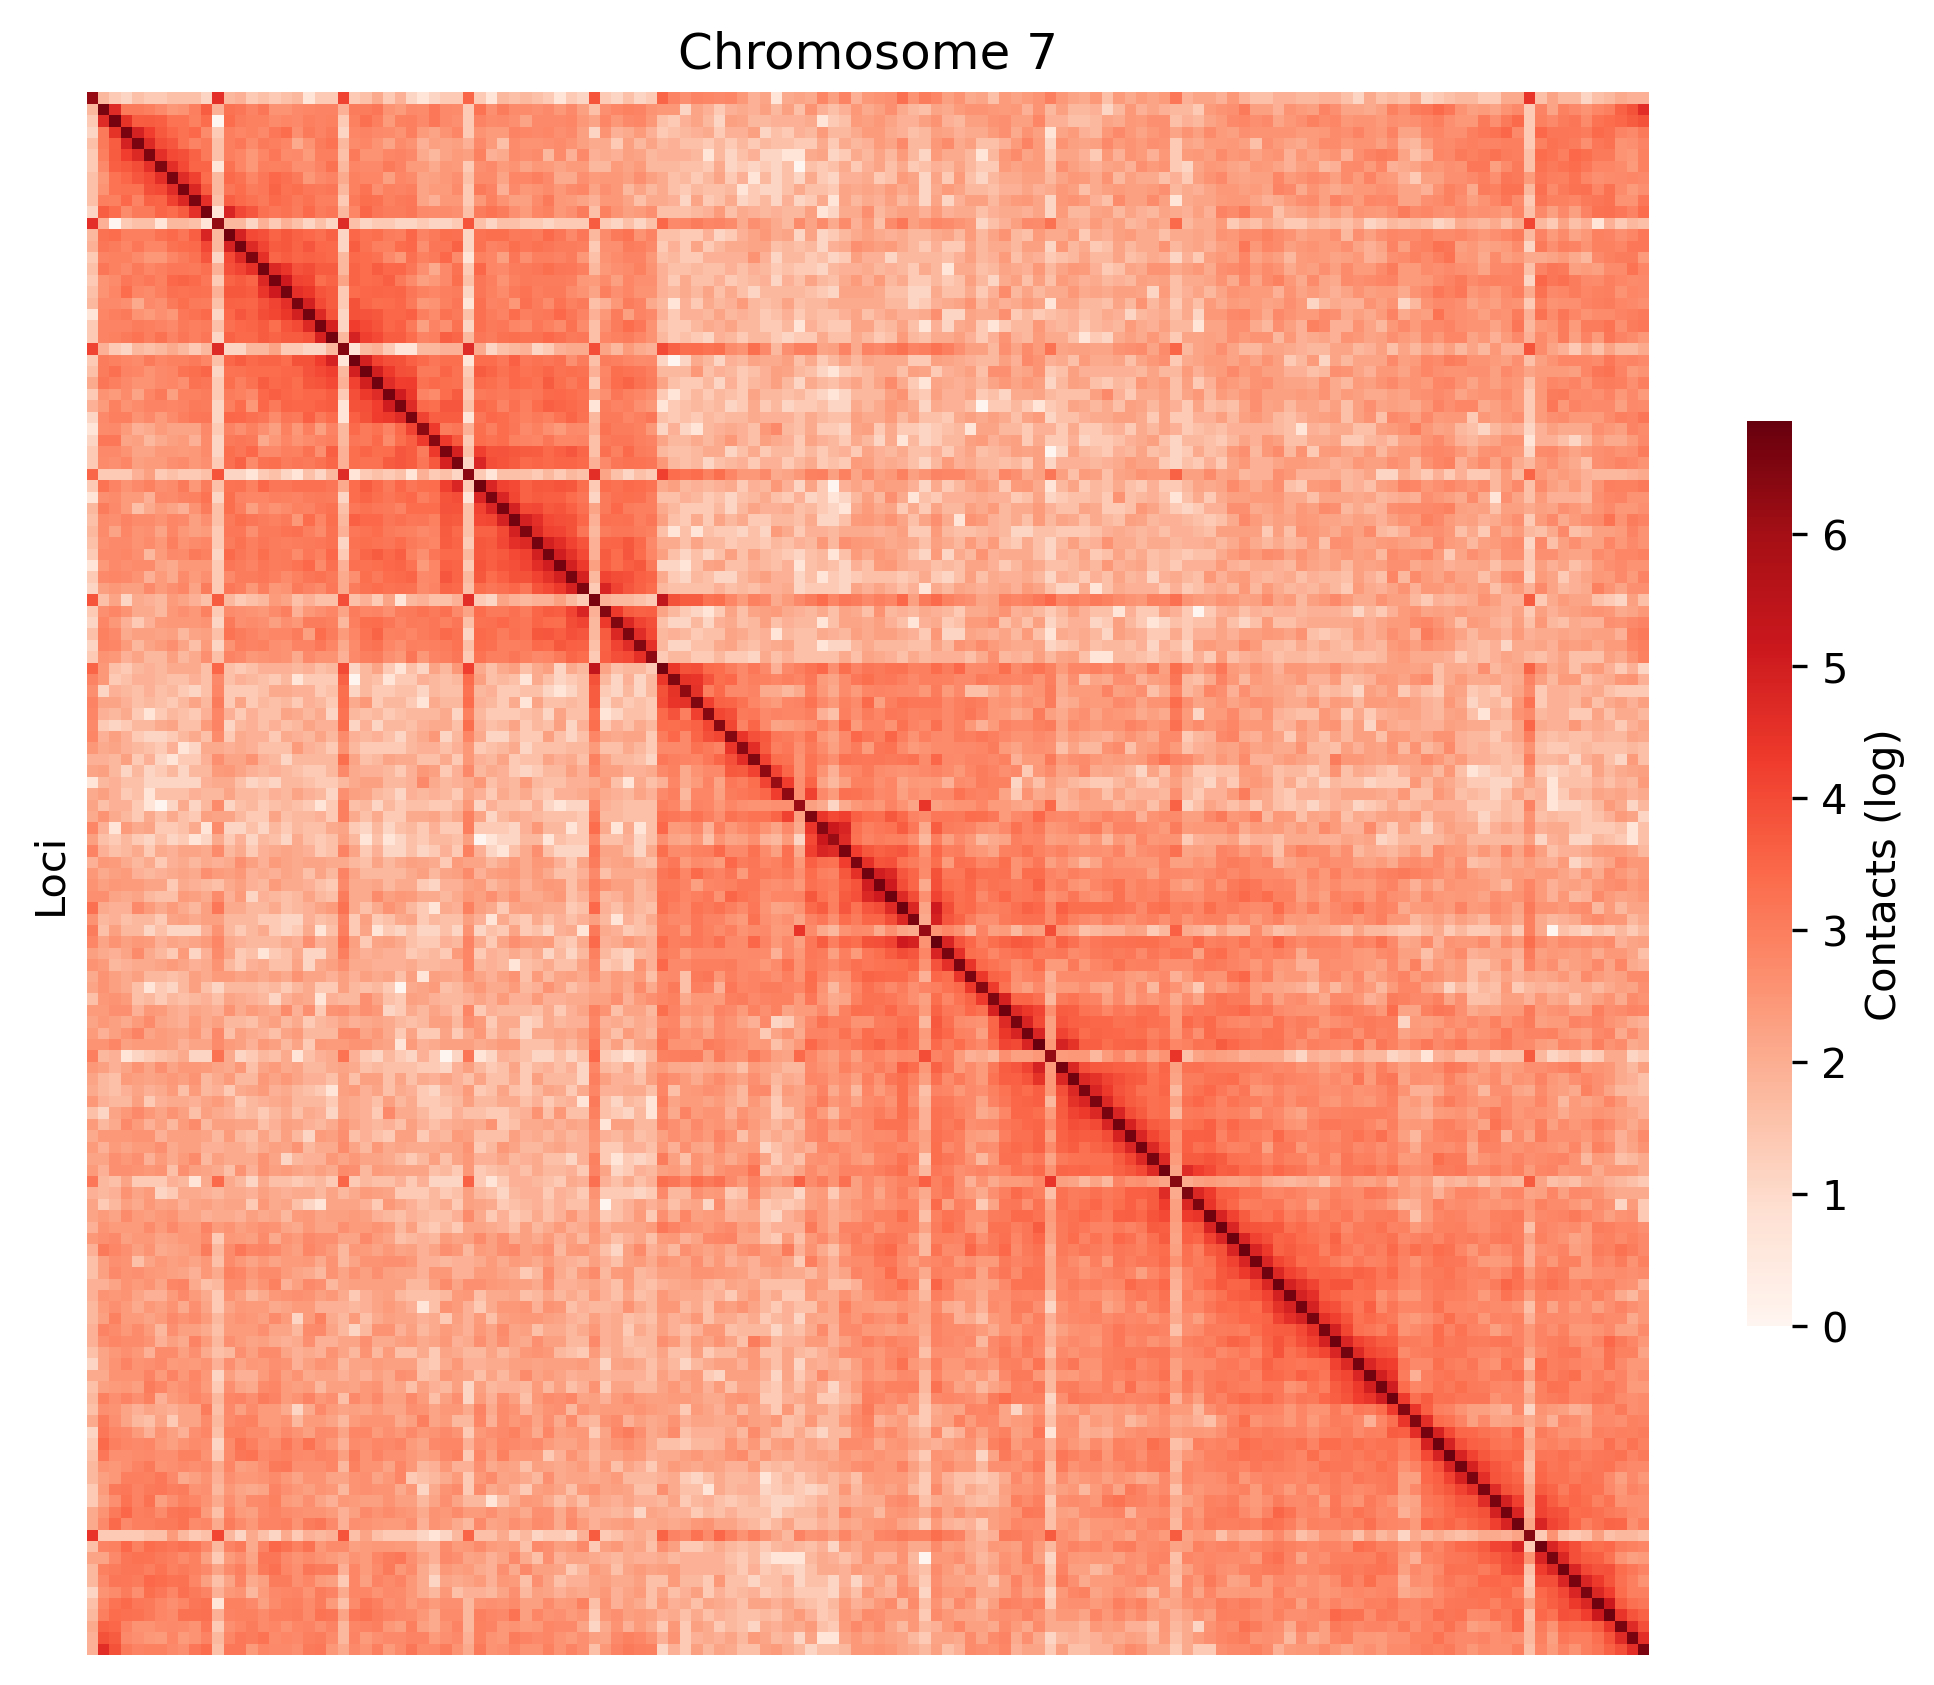

In [31]:
plot_clique_matrix_from_adata(adata)

In [43]:
H = adata.to_df()
print(f"Total: {H.shape=}")
H_u = H.T.drop_duplicates().T
print(f"Unique: {H_u.shape=}")

# (optional) order distribution
order_counts = H.astype(bool).sum(axis=0).value_counts().sort_index()
print(order_counts)

Total: H.shape=(137, 85534)
Unique: H_u.shape=(137, 31645)
0       534
1      2930
2     55922
3     16844
4      5767
5      2205
6       829
7       304
8       115
9        43
10       23
11       11
12        4
13        2
20        1
Name: count, dtype: int64


In [40]:
def plot_clique_from_incidence(
    H: pd.DataFrame,
    title: str = "",
    drop_outliers: bool = False,
    outlier_threshold: float = 1.5,
    cmap: str = "Reds",
    dpi: int = 300,
    figsize=(7,7),
    save_path: str | None = None
):
    # 1) Clique-expand
    A = matrix.clique_expand_incidence(H, zero_diag=False)

    # 2) Sort rows/cols
    A = A.sort_index(axis=0)
    A = A.sort_index(axis=1)

    # # 3) Optionally drop outlier/repeat rows+cols
    # if drop_outliers:
    #     outlier_indices = matrix.find_outlier_row_indices(A, threshold=outlier_threshold)
    #     print(f"{title} -> outlier_indices={outlier_indices}")
    #     A = A.drop(index=outlier_indices, errors="ignore")
    #     A = A.drop(columns=outlier_indices, errors="ignore")

    # print(f"{title} -> A.shape={A.shape}")

    # 4) Plot
    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams['figure.figsize'] = figsize

    ax = sns.heatmap(
        np.log1p(A.values),
        cmap=cmap,
        square=True,
        cbar_kws={'shrink': 0.45, 'label': 'Contacts (log)'}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title if title else "Clique-expanded Pore-C (single cell)")
    ax.set_ylabel("Loci (1Mb)")
    ax.set_xlabel("")
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


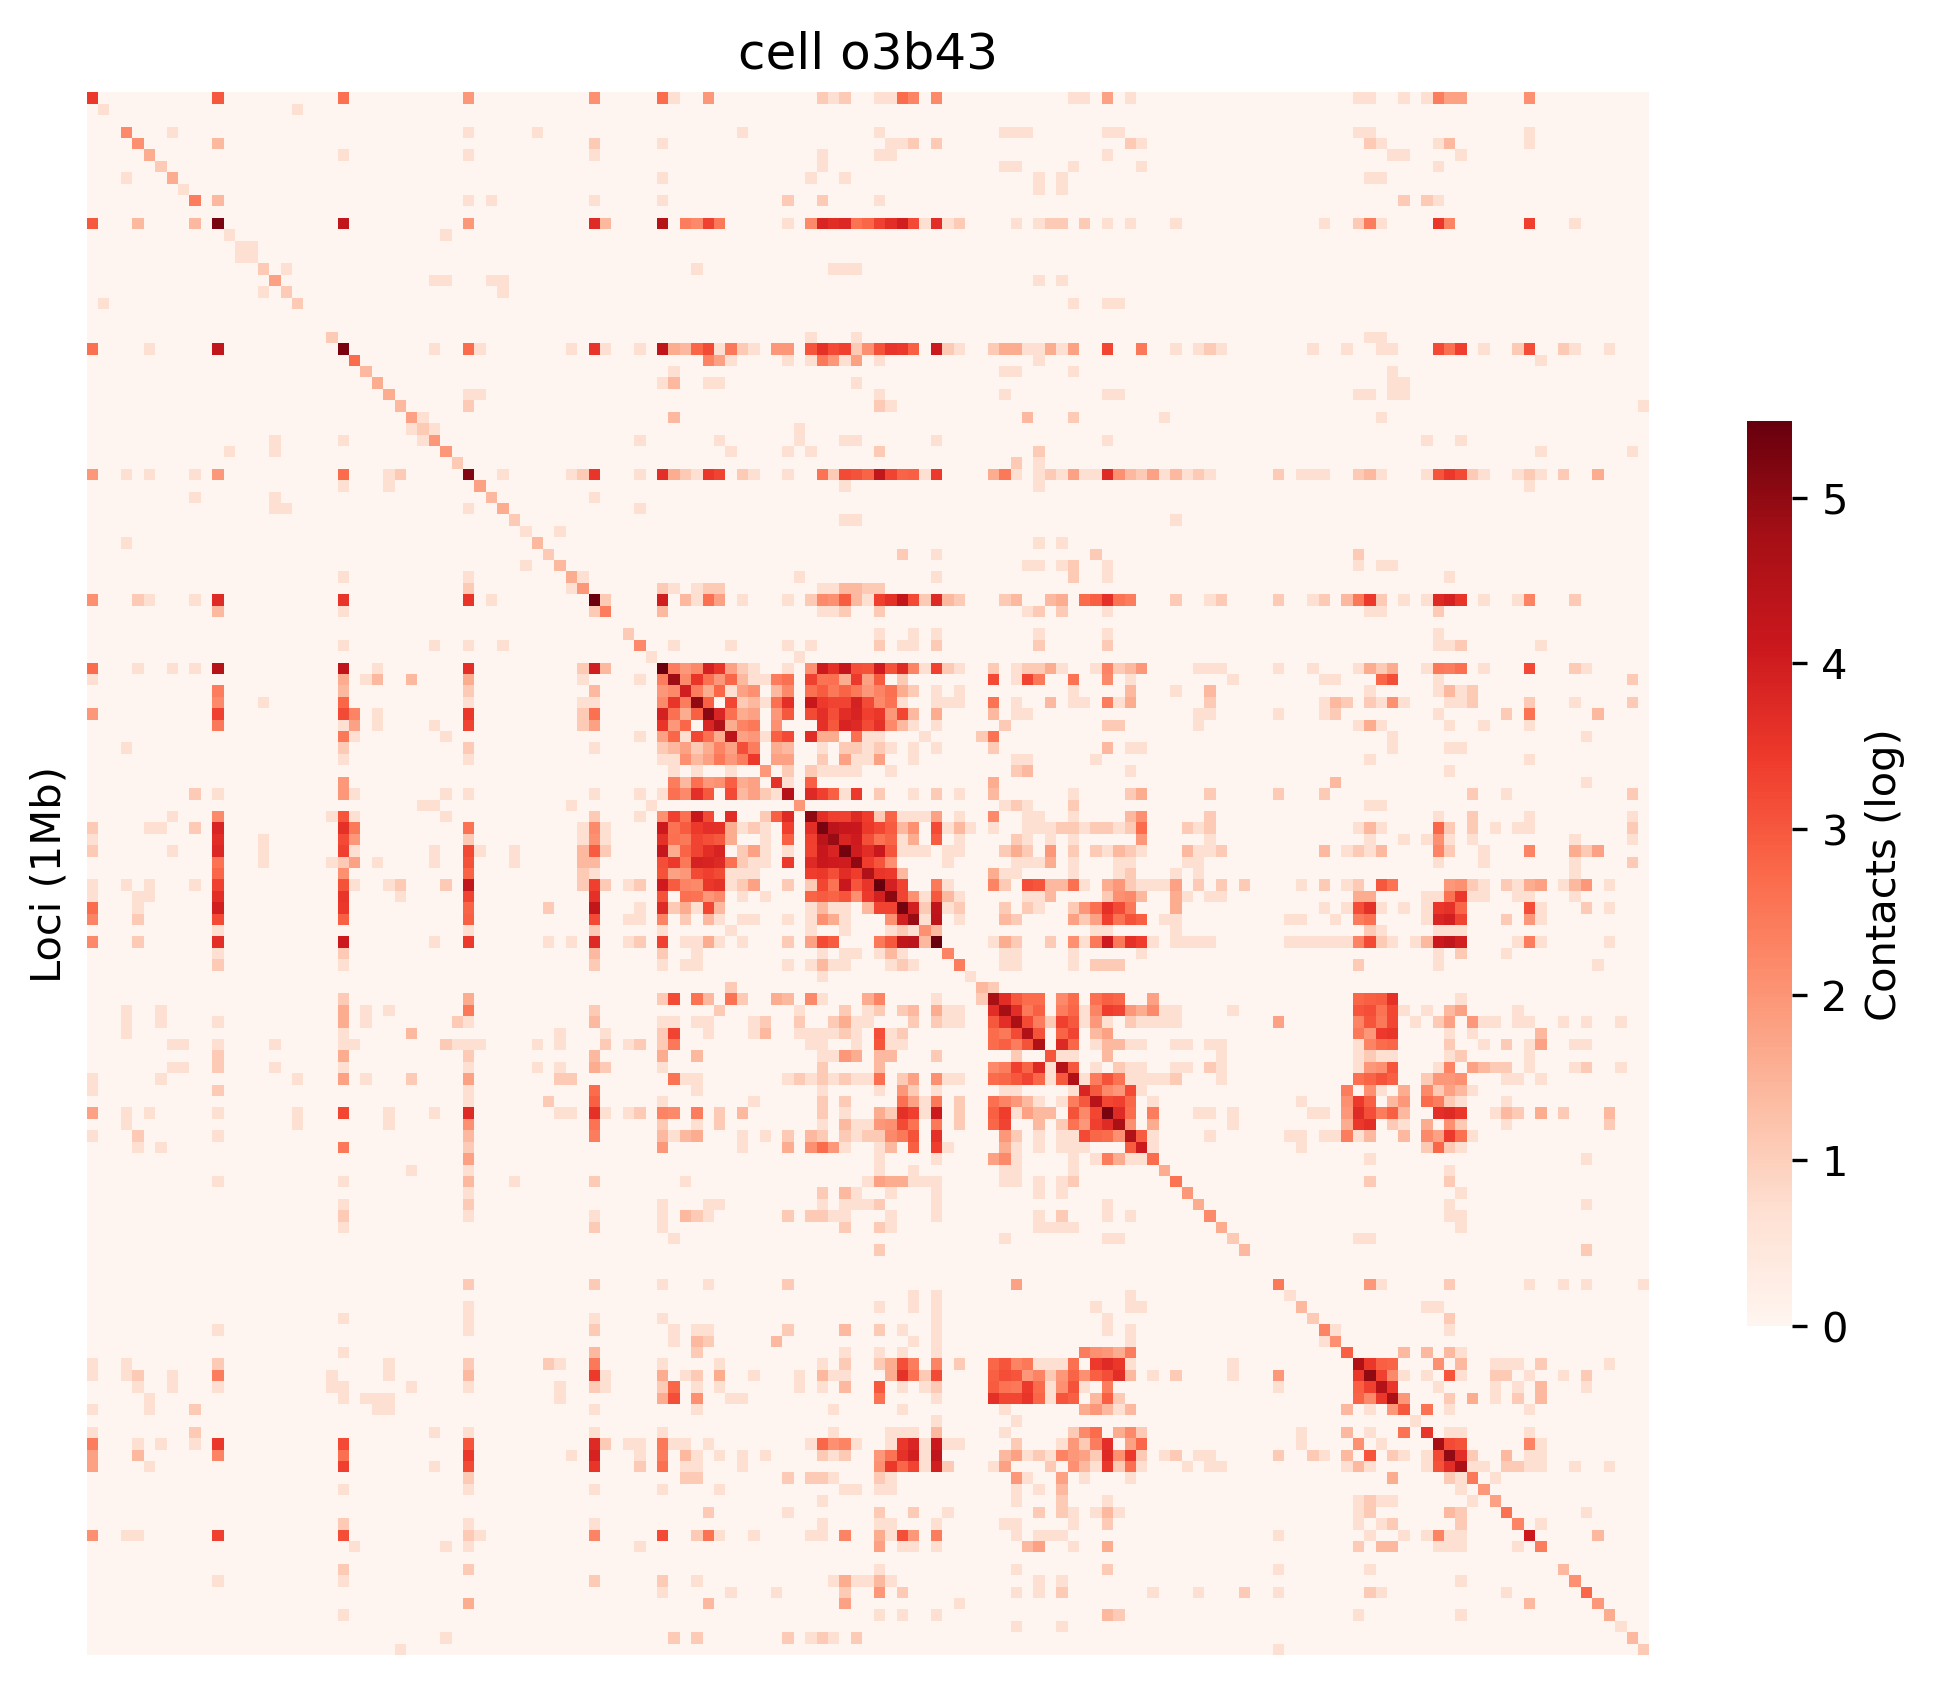

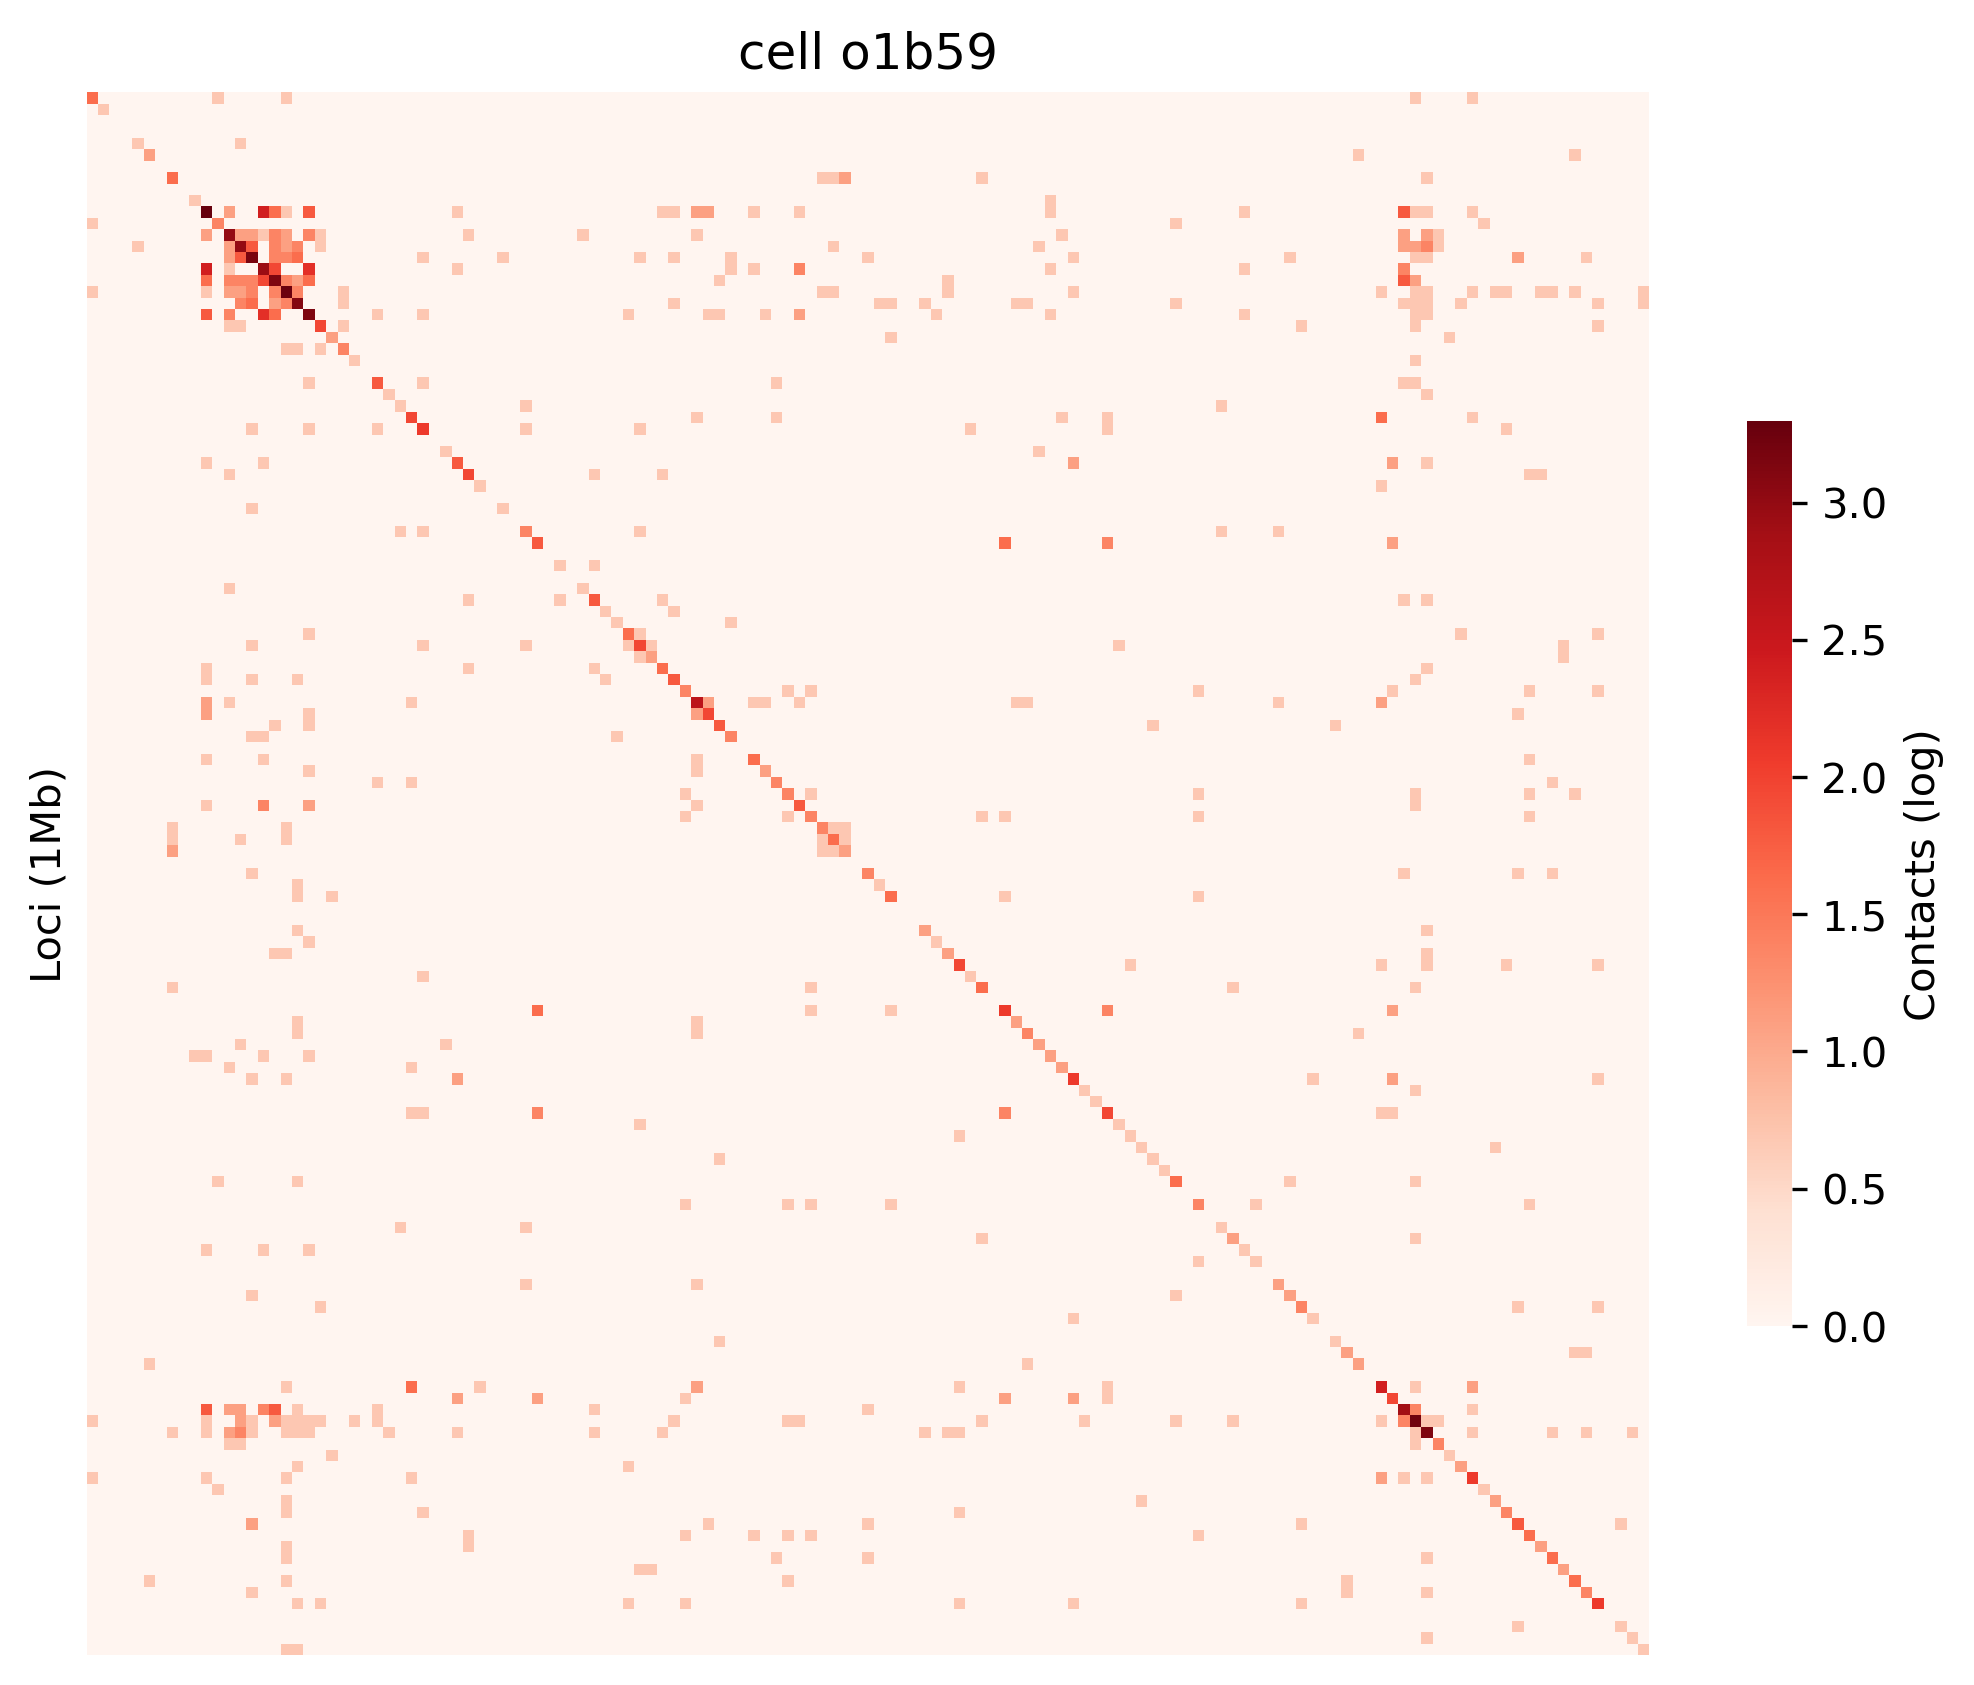

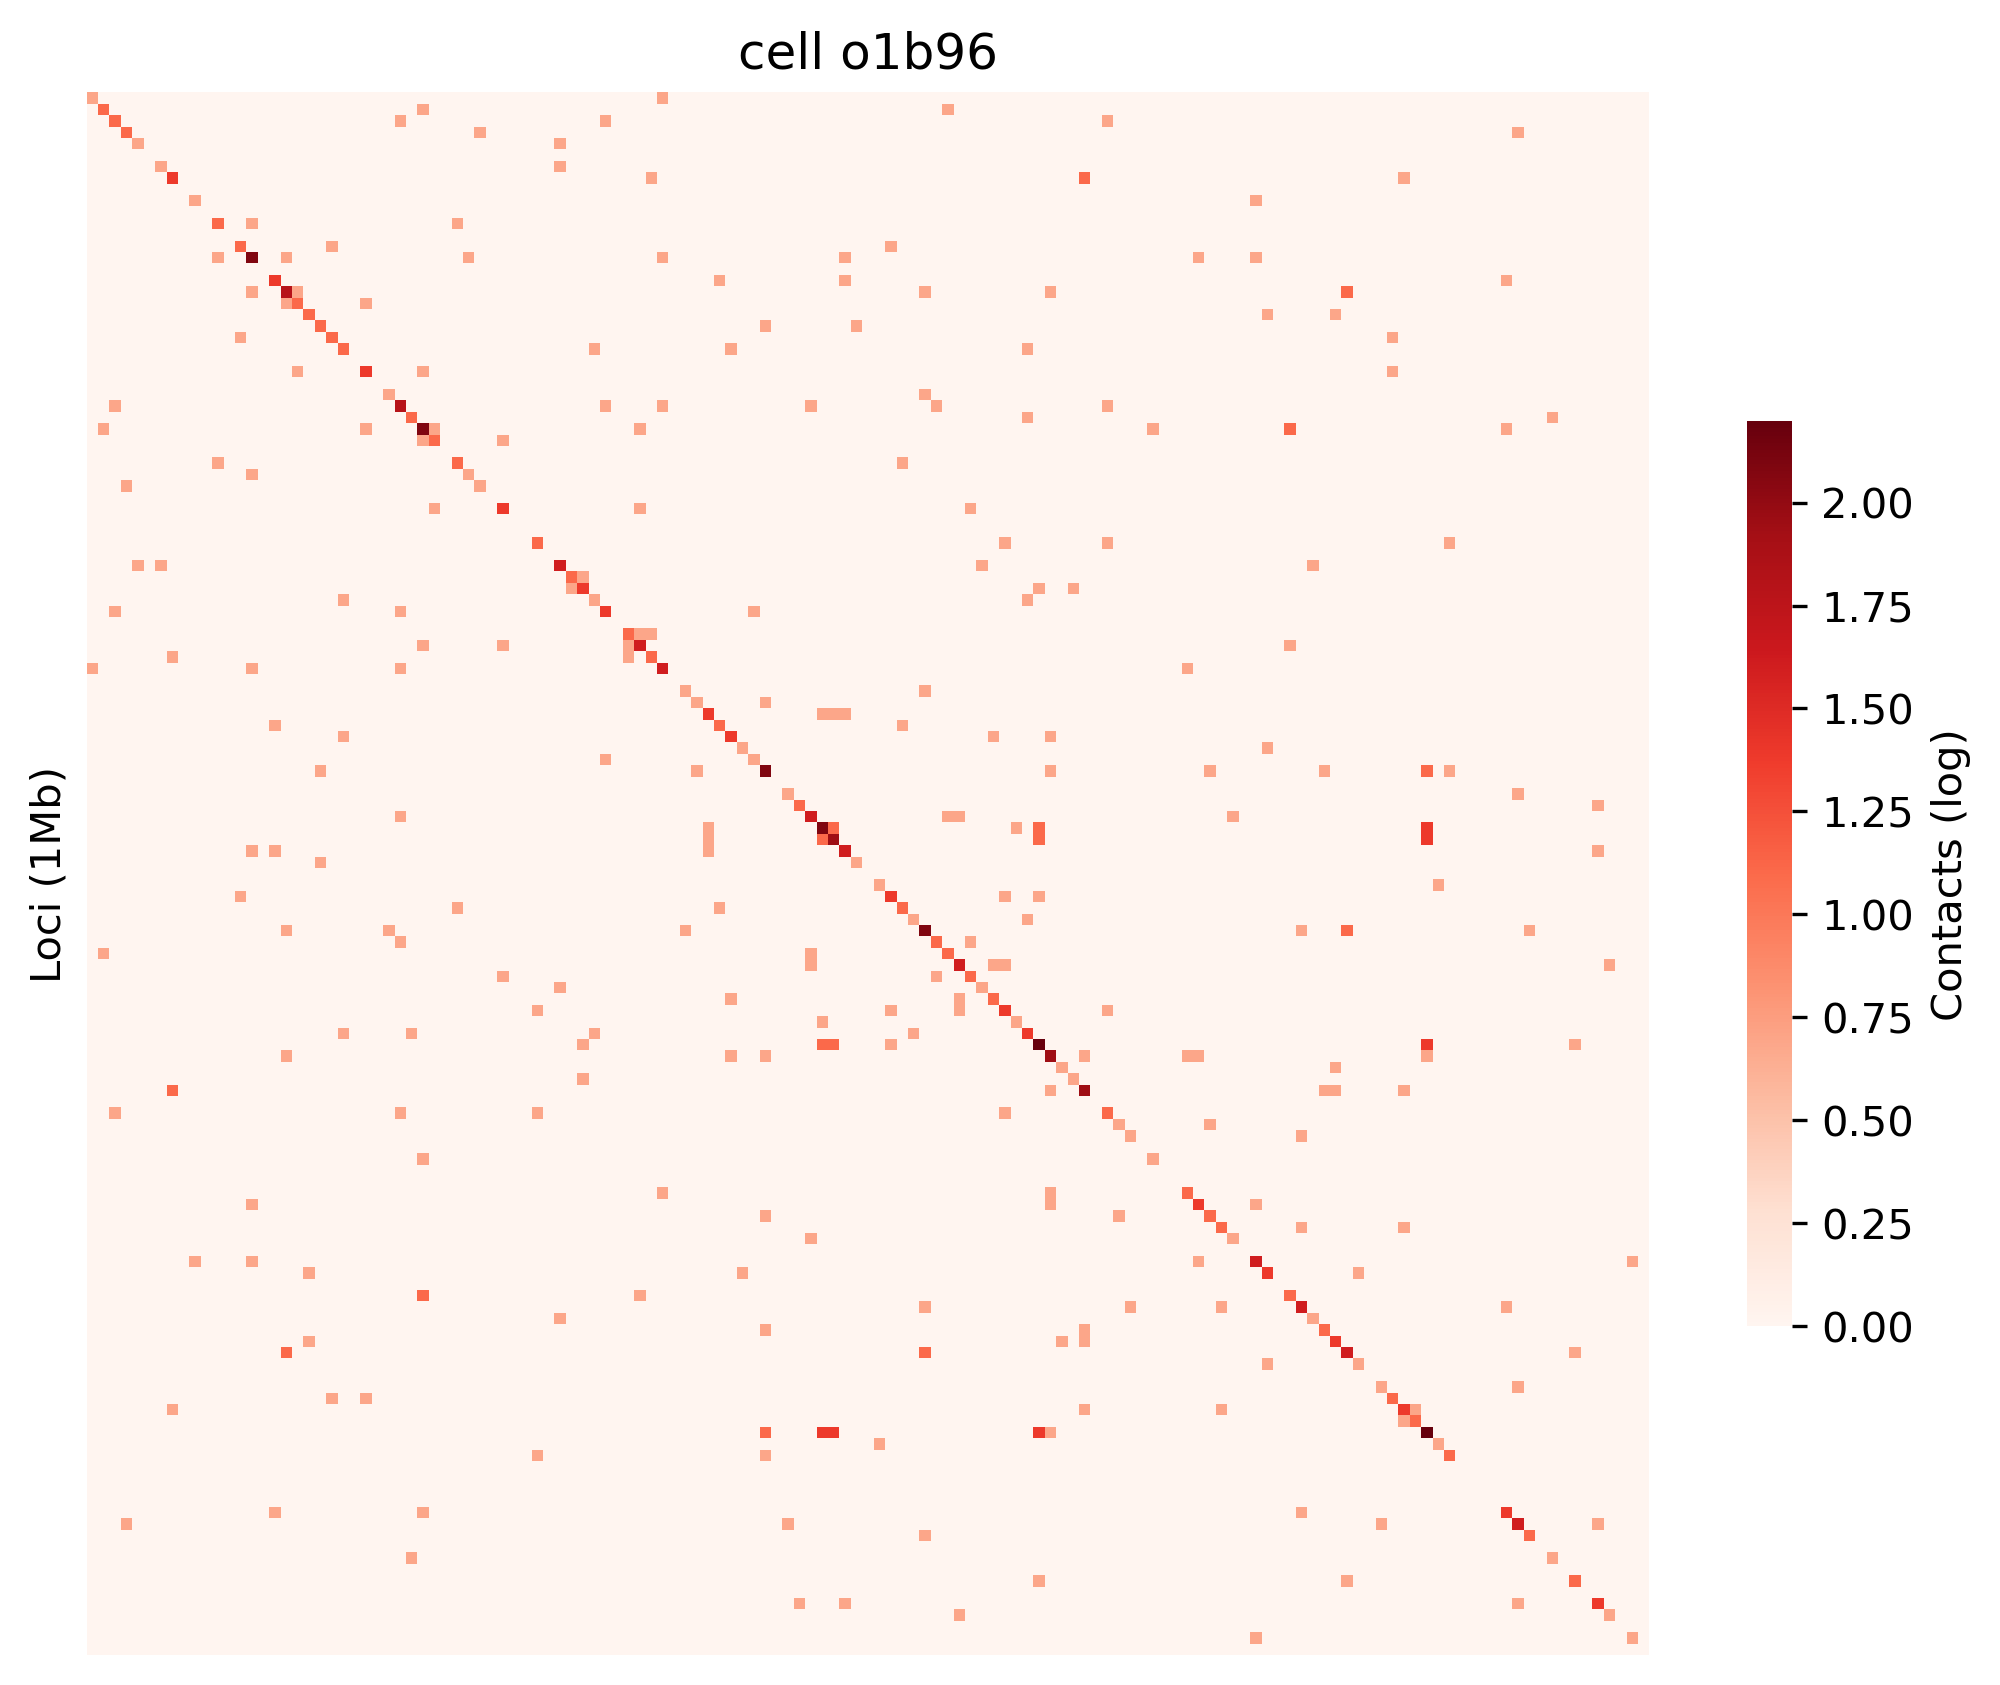

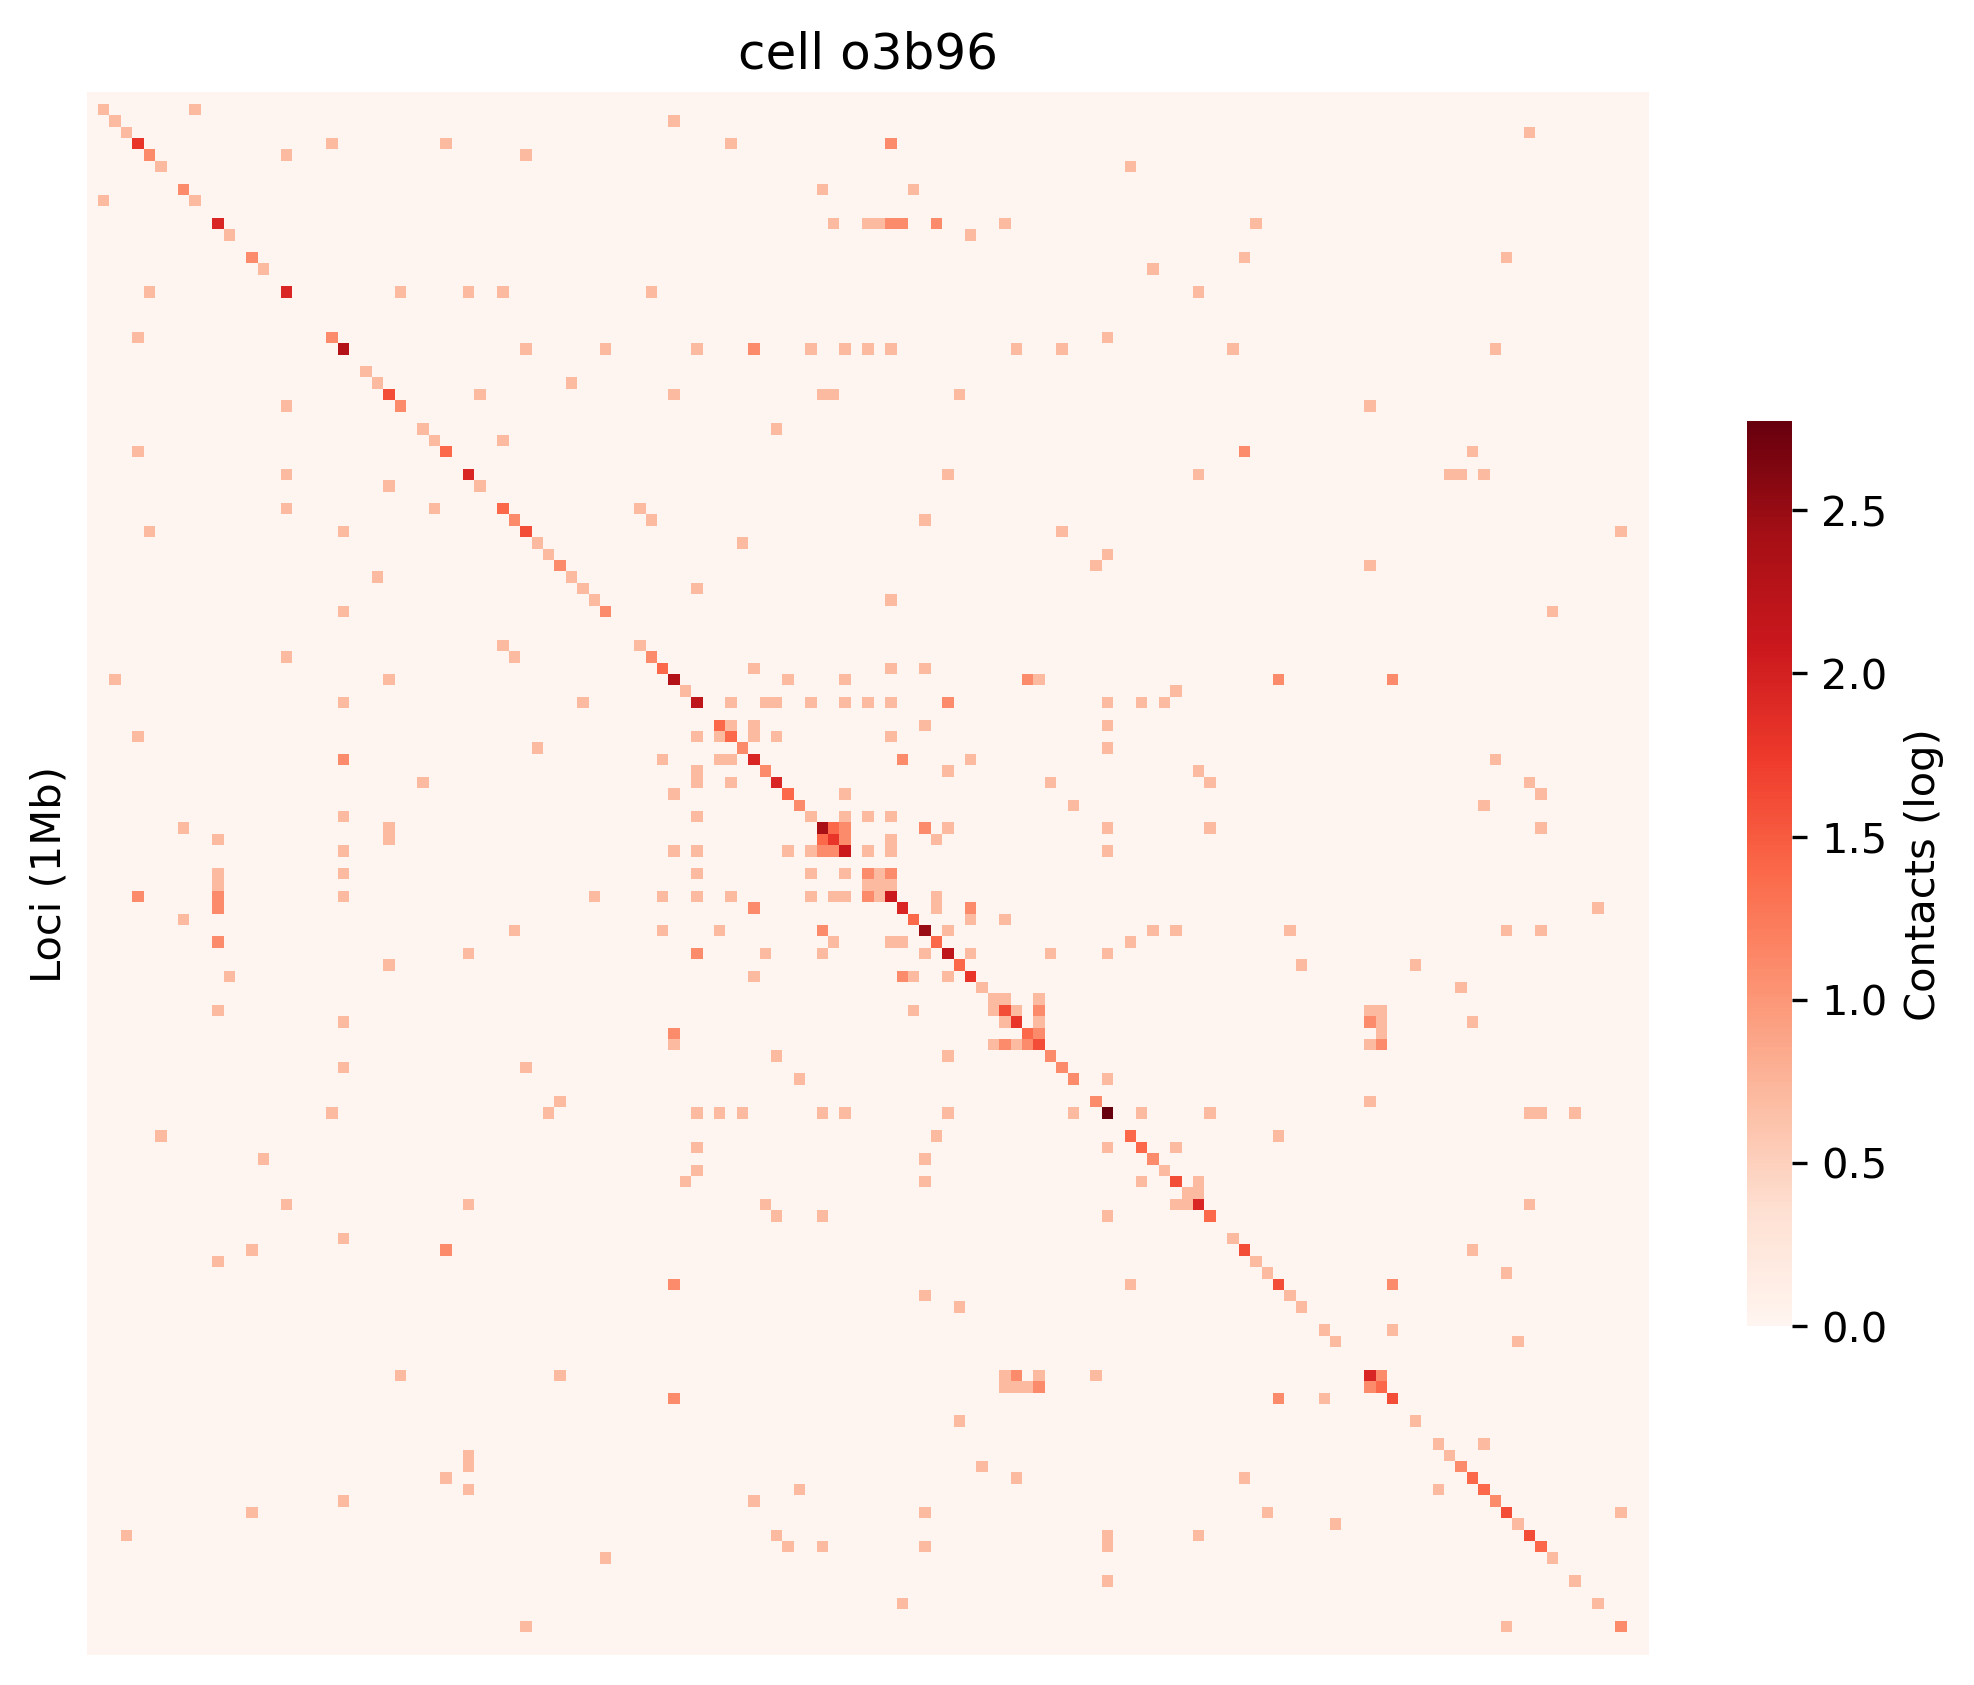

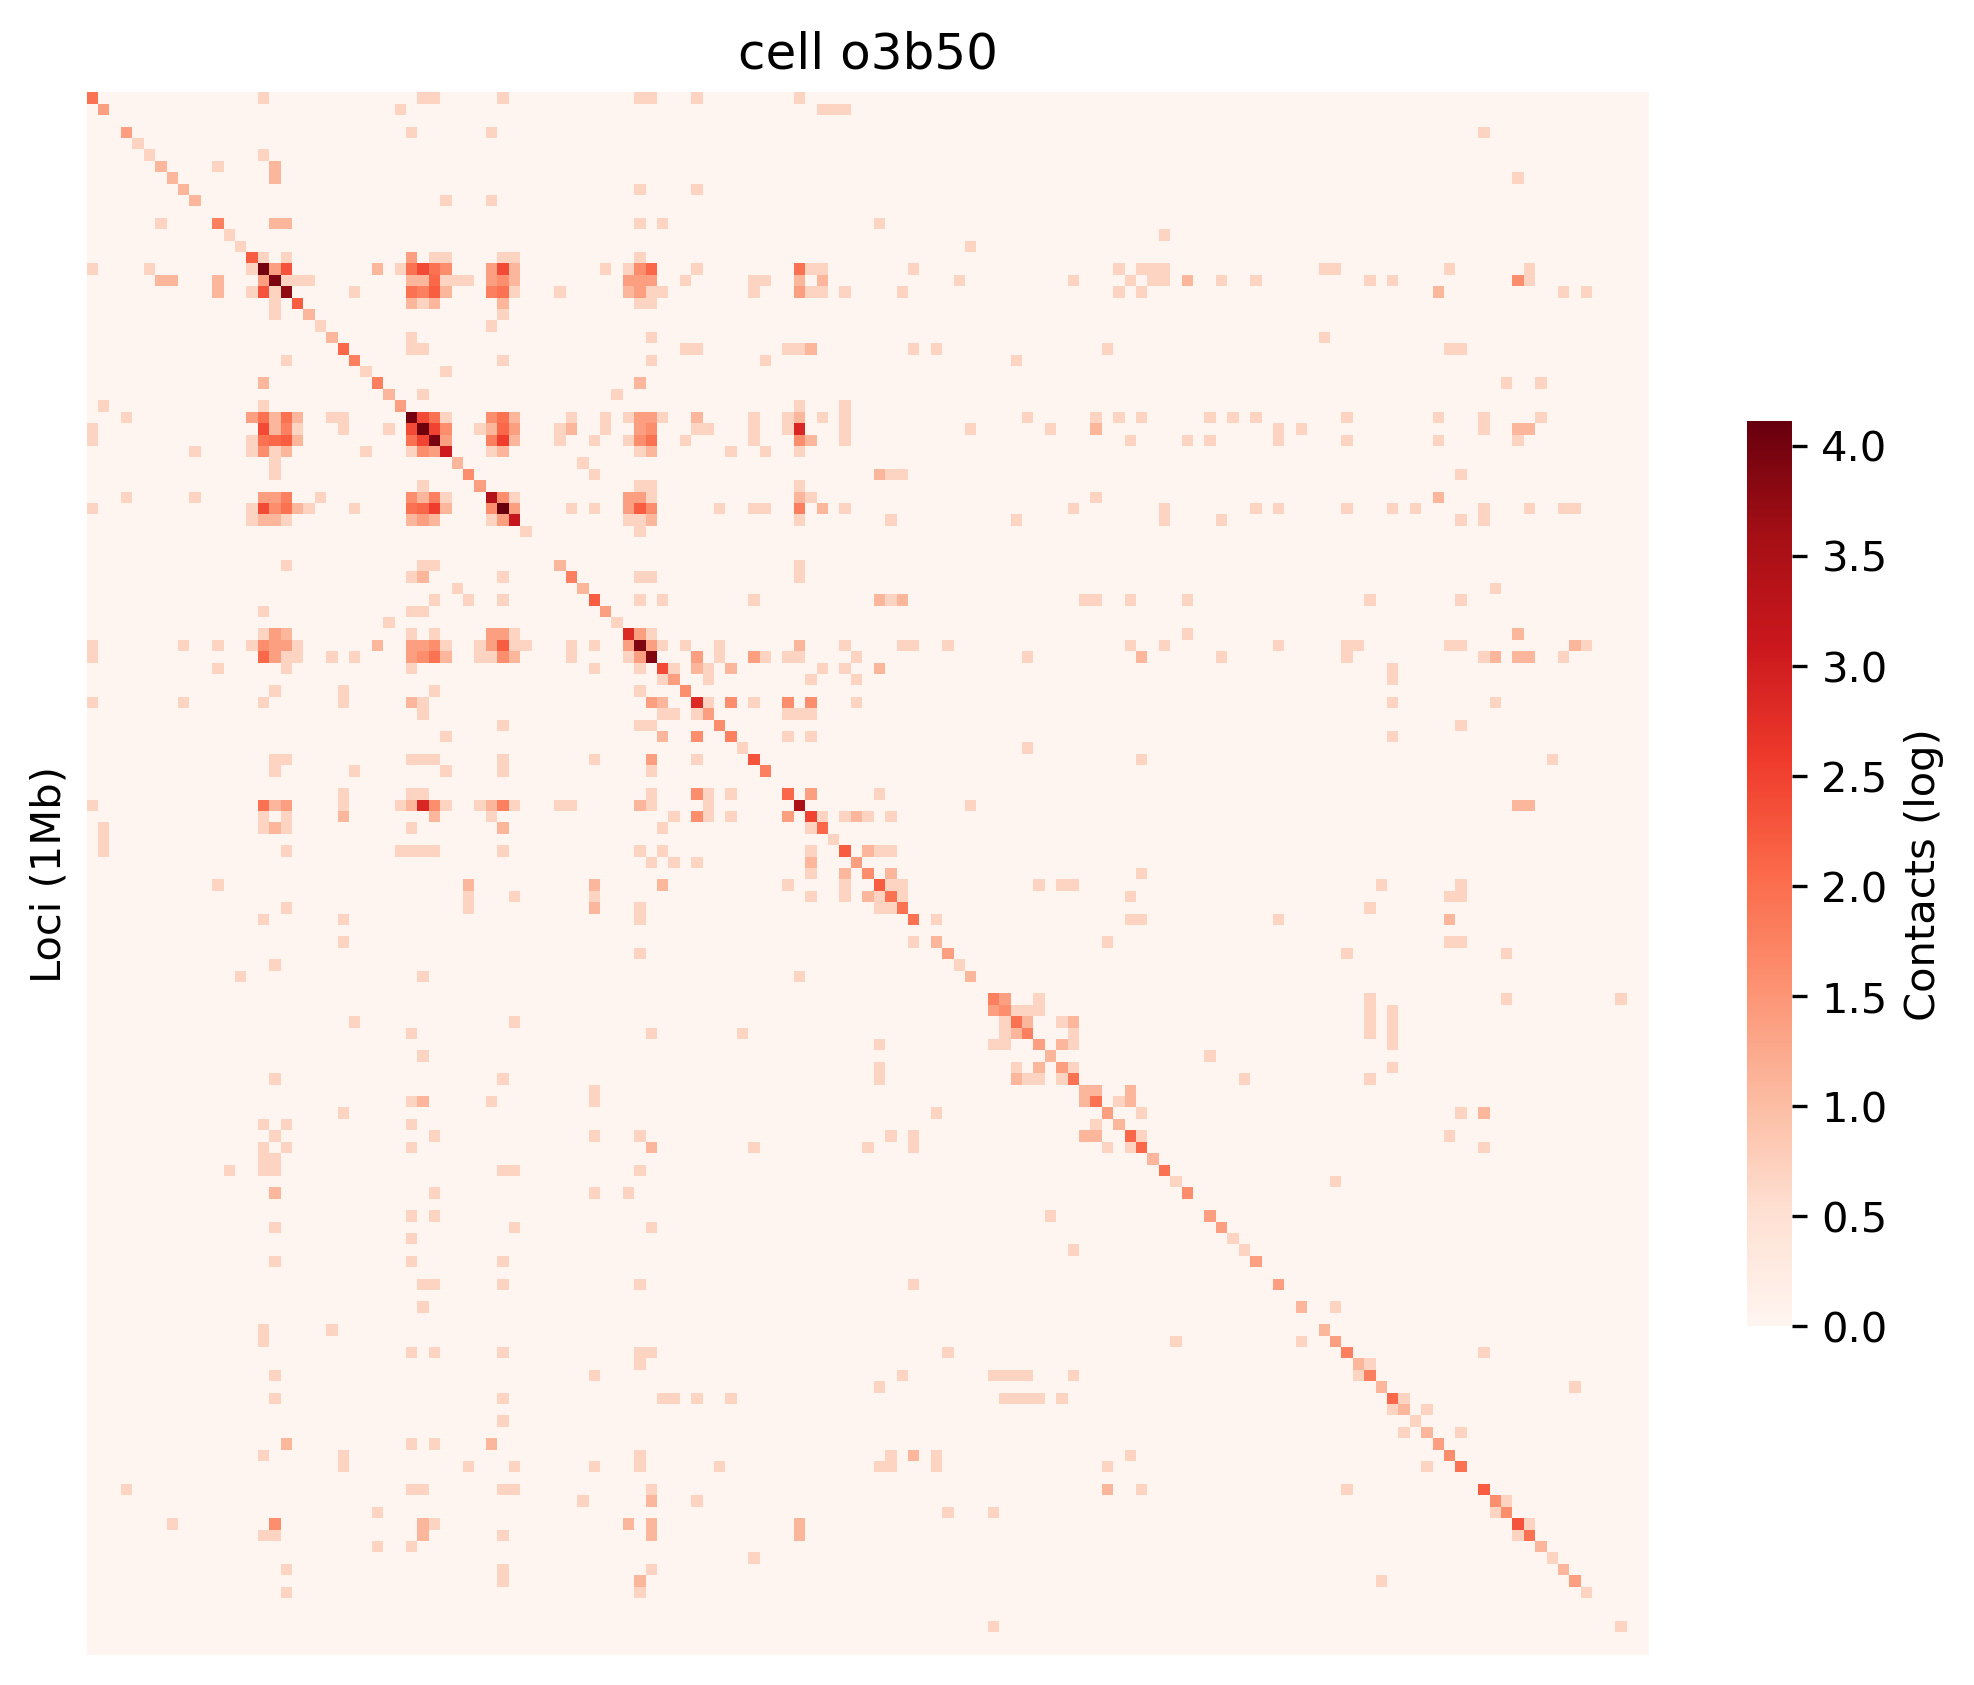

In [41]:
for cell_id, H_o in incidence_matrices.items():
    plot_clique_from_incidence(
        H_o,
        title=f"cell {cell_id}",
        outlier_threshold=1,
        save_path=None  # e.g., f"figs/{cell_id}_clique_heatmap.png"
    )